# Texas Power Grid Forecasting

## Overview

In 2021, there was a severe winter storm that pushed the Texas power grid to the point of failure. The balancing authority, Electric Reliability Council of Texas (ERCOT), covers the majority of the state and is disconnected from other US balancing authorities. Since grid failures like this proved to be catastrophic, our analysis aims to better prepare the region through predictive timeseries modeling. We used the interchange value, which is the net power generation minus the demand, and created a SARIMAX forecasting model to predict changes in the state of the grid. We used weather data as exogenous variables from four regions across Texas, and found that max temperature was the most statistically significant variable to predict interchange value. We then evaluated our model based on how accurately it predicted points where the interchange value switched sign between positive and negative, signaling an important difference between demand and energy generated.

## Data Understanding

For this project we sourced grid data from U.S. governement's Energy Information Association https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48
and weather data from NOAA's National Centers for Environmental Information 
https://www.ncei.noaa.gov/cdo-web/. The data we used was taken from a period between 2018-2022 and focused specifically on the state of Texas.

In [1]:
# Libraries we need for this project
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

In [ ]:
# # Importing CSV files of the US power grid 2018 to 2022, to create a single CSV of only data
# # from the Texas power grid balancing authority ERCOT, then saving to texasPowerGrid.csv,
# # Downloaded from https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48
# # files too large to upload to GitHub

# JD2018 = pd.read_csv('EIA930_BALANCE_2018_Jul_Dec.csv')
# JJ2019 = pd.read_csv('EIA930_BALANCE_2019_Jan_Jun.csv')
# JD2019 = pd.read_csv('EIA930_BALANCE_2019_Jul_Dec.csv')
# JJ2020 = pd.read_csv('EIA930_BALANCE_2020_Jan_Jun.csv')
# JD2020 = pd.read_csv('EIA930_BALANCE_2020_Jul_Dec.csv')
# JJ2021 = pd.read_csv('EIA930_BALANCE_2021_Jan_Jun.csv')
# JD2021 = pd.read_csv('EIA930_BALANCE_2021_Jul_Dec.csv')
# JJ2022 = pd.read_csv('EIA930_BALANCE_2022_Jan_Jun.csv')
# JD2022 = pd.read_csv('EIA930_BALANCE_2022_Jul_Dec.csv')

# JD2017.columns == JD2018.columns  # 15 cols pre 2018, 24 after

# len(JD2018.columns)

# csvlist = [JJ2018, JD2018, JJ2019, JD2019, JJ2020, JD2020, JJ2021, JD2021, JJ2022, JD2022]

# total = pd.concat(csvlist)

# texas.set_index(pd.to_datetime(texas['UTC Time at End of Hour']), inplace=True)

# texas.to_csv('./texasPowerGrid.csv')

In [81]:
# importing Texas grid data (ERCOT) from the U.S. governement's Energy Information Association
grid = pd.read_csv("Data/texasPowerGrid.csv")

# importing weather data from NOAA's National Centers for Environmental Information 
#https://www.ncei.noaa.gov/cdo-web/
# importing El Paso Weather Data
el_paso_weather = pd.read_csv('Data/El_Paso_Weather.csv')

# importing Corpus Christi Weather Data 
corpus_christi_weather = pd.read_csv('Data/Corpus_Christi_Weather.csv')

# importing Dallas Weather Data 
dallas_weather = pd.read_csv('Data/Dallas_Weather.csv')

# importing Amarillo Weather Data
amarillo_weather = pd.read_csv('Data/Amarillo_Weather.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (11,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# exploring grid data
grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 25 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Unnamed: 0                                              43200 non-null  int64  
 1   Balancing Authority                                     43200 non-null  object 
 2   Data Date                                               43200 non-null  object 
 3   Hour Number                                             43200 non-null  int64  
 4   Local Time at End of Hour                               43200 non-null  object 
 5   UTC Time at End of Hour                                 43200 non-null  object 
 6   Demand Forecast (MW)                                    43104 non-null  object 
 7   Demand (MW)                                             43080 non-null  object 
 8   Net Generation (MW)                 

In [4]:
# exploring el paso weather dataframe
el_paso_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  1796 non-null   object 
 1   NAME     1796 non-null   object 
 2   DATE     1796 non-null   object 
 3   AWND     1796 non-null   float64
 4   PGTM     64 non-null     float64
 5   PRCP     1796 non-null   float64
 6   SNOW     1796 non-null   float64
 7   SNWD     1788 non-null   float64
 8   TAVG     1796 non-null   int64  
 9   TMAX     1796 non-null   int64  
 10  TMIN     1795 non-null   float64
 11  WDF2     1796 non-null   int64  
 12  WDF5     1789 non-null   float64
 13  WSF2     1796 non-null   float64
 14  WSF5     1789 non-null   float64
 15  WT01     82 non-null     float64
 16  WT02     7 non-null      float64
 17  WT03     210 non-null    float64
 18  WT04     3 non-null      float64
 19  WT05     7 non-null      float64
 20  WT07     56 non-null     float64
 21  WT08     122 n

In [5]:
# exploring corpus christi weather dataframe
corpus_christi_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  1796 non-null   object 
 1   NAME     1796 non-null   object 
 2   DATE     1796 non-null   object 
 3   AWND     1793 non-null   float64
 4   PGTM     36 non-null     float64
 5   PRCP     1796 non-null   float64
 6   SNOW     1796 non-null   float64
 7   SNWD     1796 non-null   float64
 8   TAVG     1796 non-null   int64  
 9   TMAX     1796 non-null   int64  
 10  TMIN     1796 non-null   int64  
 11  WDF2     1794 non-null   float64
 12  WDF5     1792 non-null   float64
 13  WSF2     1794 non-null   float64
 14  WSF5     1792 non-null   float64
 15  WT01     846 non-null    float64
 16  WT02     145 non-null    float64
 17  WT03     240 non-null    float64
 18  WT04     2 non-null      float64
 19  WT08     170 non-null    float64
dtypes: float64(14), int64(3), object(3)
memory usage: 28

In [6]:
# exploring dallas weather dataframe
dallas_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  1796 non-null   object 
 1   NAME     1796 non-null   object 
 2   DATE     1796 non-null   object 
 3   AWND     1796 non-null   float64
 4   PRCP     1796 non-null   float64
 5   SNOW     1796 non-null   float64
 6   SNWD     1796 non-null   float64
 7   TAVG     1796 non-null   int64  
 8   TMAX     1796 non-null   int64  
 9   TMIN     1796 non-null   int64  
 10  WDF2     1796 non-null   int64  
 11  WDF5     1793 non-null   float64
 12  WSF2     1796 non-null   float64
 13  WSF5     1793 non-null   float64
 14  WT01     497 non-null    float64
 15  WT02     45 non-null     float64
 16  WT03     294 non-null    float64
 17  WT04     11 non-null     float64
 18  WT05     9 non-null      float64
 19  WT06     15 non-null     float64
 20  WT07     6 non-null      float64
 21  WT08     142 n

In [7]:
# exploring amarillo weather dataframe
amarillo_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  1796 non-null   object 
 1   NAME     1796 non-null   object 
 2   DATE     1796 non-null   object 
 3   AWND     1796 non-null   float64
 4   PGTM     68 non-null     float64
 5   PRCP     1796 non-null   float64
 6   PSUN     1 non-null      float64
 7   SNOW     1796 non-null   float64
 8   SNWD     1794 non-null   float64
 9   TAVG     1796 non-null   int64  
 10  TMAX     1796 non-null   int64  
 11  TMIN     1796 non-null   int64  
 12  TSUN     1 non-null      float64
 13  WDF2     1796 non-null   int64  
 14  WDF5     1795 non-null   float64
 15  WSF2     1796 non-null   float64
 16  WSF5     1795 non-null   float64
 17  WT01     401 non-null    float64
 18  WT02     86 non-null     float64
 19  WT03     255 non-null    float64
 20  WT05     21 non-null     float64
 21  WT06     8 non

## Data Preparation

### Converting Index to Datetime

In [8]:
# converting grid dataframe index to UTC datetime
grid.set_index(pd.to_datetime(grid['UTC Time at End of Hour']), inplace= True)

# creating grid dataframe with only 'Total Interchange (MW)' column (target)
grid = pd.DataFrame(grid['Total Interchange (MW)'])

# checking grid dataframe
grid.head()

,Total Interchange (MW)
UTC Time at End of Hour,
2018-01-01 07:00:00,212
2018-01-01 08:00:00,385
2018-01-01 09:00:00,150
2018-01-01 10:00:00,398
2018-01-01 11:00:00,321


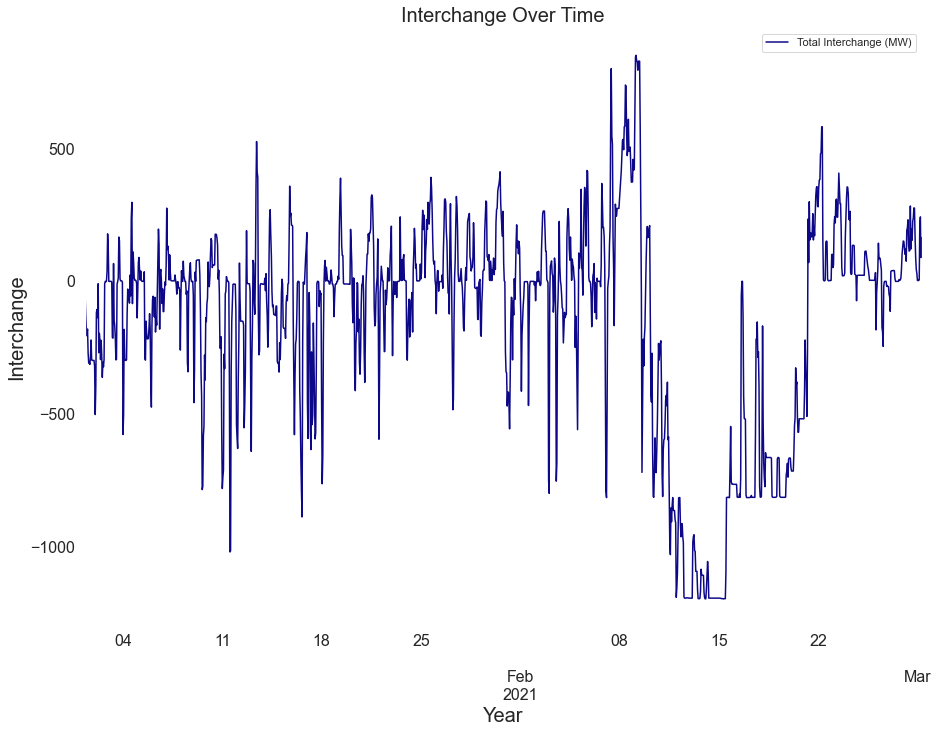

In [63]:
# plotting total interchange in 2021 to show the year of the snowstorm and energy crisis

grid['2021-01-01 07:00:00':'2021-03-01 07:00:00'].plot(figsize=(15,11), title='Interchange Over Time', colormap='plasma',
                                                             ylabel='', xlabel='', fontsize=16 )
plt.title('Interchange Over Time', fontsize=20)
plt.ylabel('Interchange', fontsize=20)
plt.xlabel('Year', fontsize=20)
rc={'axes.facecolor':'white', 'figure.facecolor':'white'}

We wanted to explore the correlation of four different weather conditions on the net interchange of Texas' grid. Hypothesizing that extreme values of wind, snow, rain and temperature may relate to changes in the grid's interchange values.

In [9]:
# converting weather dataframes indexes to datetime
weather_station_list = [el_paso_weather, corpus_christi_weather, dallas_weather, amarillo_weather]

for station in weather_station_list:
    station.set_index(pd.to_datetime(station['DATE']), inplace=True)  

In [10]:
# compiling new weather dataframe with only columns of interest (Average Wind Speed(mph), Precipitation(in), Snow(in), Max Tempereature,
# and Min Temperature(F)) from each station
weather = pd.DataFrame()

weather['el_paso_AWND'] = el_paso_weather['AWND']
weather['corpus_christi_AWND'] = corpus_christi_weather['AWND']
weather['dallas_AWND'] = dallas_weather['AWND']
weather['amarillo_AWND'] = amarillo_weather['AWND']

weather['el_paso_PRCP'] = el_paso_weather['PRCP']
weather['corpus_christi_PRCP'] = corpus_christi_weather['PRCP']
weather['dallas_PRCP'] = dallas_weather['PRCP']
weather['amarillo_PRCP'] = amarillo_weather['PRCP']

weather['el_paso_SNOW'] = el_paso_weather['SNOW']
weather['corpus_christi_SNOW'] = corpus_christi_weather['SNOW']
weather['dallas_SNOW'] = dallas_weather['SNOW']
weather['amarillo_SNOW'] = amarillo_weather['SNOW']

weather['el_paso_TMAX'] = el_paso_weather['TMAX']
weather['corpus_christi_TMAX'] = corpus_christi_weather['TMAX']
weather['dallas_TMAX'] = dallas_weather['TMAX']
weather['amarillo_TMAX'] = amarillo_weather['TMAX']

weather['el_paso_TMIN'] = el_paso_weather['TMIN']
weather['corpus_christi_TMIN'] = corpus_christi_weather['TMIN']
weather['dallas_TMIN'] = dallas_weather['TMIN']
weather['amarillo_TMIN'] = amarillo_weather['TMIN']

# checking new weather dataframe
weather.head()

,el_paso_AWND,corpus_christi_AWND,dallas_AWND,amarillo_AWND,el_paso_PRCP,corpus_christi_PRCP,dallas_PRCP,amarillo_PRCP,el_paso_SNOW,corpus_christi_SNOW,dallas_SNOW,amarillo_SNOW,el_paso_TMAX,corpus_christi_TMAX,dallas_TMAX,amarillo_TMAX,el_paso_TMIN,corpus_christi_TMIN,dallas_TMIN,amarillo_TMIN
DATE,,,,,,,,,,,,,,,,,,,,
2018-01-01,5.14,16.78,11.41,9.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,37,30,21,27.0,32,17,4
2018-01-02,5.14,15.43,8.05,9.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57,39,28,30,30.0,31,21,2
2018-01-03,3.80,10.74,7.61,8.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,52,50,53,24.0,27,19,14
2018-01-04,5.59,5.14,3.36,9.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,59,51,52,37.0,29,27,23
2018-01-05,4.25,8.28,6.26,7.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,62,64,57,32.0,41,31,22


### Data Cleaning

In [11]:
# checking null and missing values in grid dataframe
grid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43200 entries, 2018-01-01 07:00:00 to 2022-12-06 06:00:00
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Total Interchange (MW)  43075 non-null  object
dtypes: object(1)
memory usage: 675.0+ KB


In [12]:
# dropping null values
grid.dropna(inplace=True)

# confirming we dropped all nulls
grid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43075 entries, 2018-01-01 07:00:00 to 2022-12-05 06:00:00
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Total Interchange (MW)  43075 non-null  object
dtypes: object(1)
memory usage: 673.0+ KB


In [13]:
# convertng target object data type to int
grid = pd.DataFrame(grid['Total Interchange (MW)'].str.replace(',', '').astype(int))

# confirming we converted target data type
grid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43075 entries, 2018-01-01 07:00:00 to 2022-12-05 06:00:00
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Total Interchange (MW)  43075 non-null  int64
dtypes: int64(1)
memory usage: 673.0 KB


In [14]:
# checking null and missing values in weather dataframe
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1796 entries, 2018-01-01 to 2022-12-01
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   el_paso_AWND         1796 non-null   float64
 1   corpus_christi_AWND  1793 non-null   float64
 2   dallas_AWND          1796 non-null   float64
 3   amarillo_AWND        1796 non-null   float64
 4   el_paso_PRCP         1796 non-null   float64
 5   corpus_christi_PRCP  1796 non-null   float64
 6   dallas_PRCP          1796 non-null   float64
 7   amarillo_PRCP        1796 non-null   float64
 8   el_paso_SNOW         1796 non-null   float64
 9   corpus_christi_SNOW  1796 non-null   float64
 10  dallas_SNOW          1796 non-null   float64
 11  amarillo_SNOW        1796 non-null   float64
 12  el_paso_TMAX         1796 non-null   int64  
 13  corpus_christi_TMAX  1796 non-null   int64  
 14  dallas_TMAX          1796 non-null   int64  
 15  amarillo_TMAX       

In [15]:
# backfilling null values for average wind data for corpus cristi station
weather['corpus_christi_AWND'].bfill(inplace=True)
weather['el_paso_TMIN'].bfill(inplace=True)

# confirming null values were backfilled
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1796 entries, 2018-01-01 to 2022-12-01
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   el_paso_AWND         1796 non-null   float64
 1   corpus_christi_AWND  1796 non-null   float64
 2   dallas_AWND          1796 non-null   float64
 3   amarillo_AWND        1796 non-null   float64
 4   el_paso_PRCP         1796 non-null   float64
 5   corpus_christi_PRCP  1796 non-null   float64
 6   dallas_PRCP          1796 non-null   float64
 7   amarillo_PRCP        1796 non-null   float64
 8   el_paso_SNOW         1796 non-null   float64
 9   corpus_christi_SNOW  1796 non-null   float64
 10  dallas_SNOW          1796 non-null   float64
 11  amarillo_SNOW        1796 non-null   float64
 12  el_paso_TMAX         1796 non-null   int64  
 13  corpus_christi_TMAX  1796 non-null   int64  
 14  dallas_TMAX          1796 non-null   int64  
 15  amarillo_TMAX       

### Checking Stationarity of Target (Total Interchange)

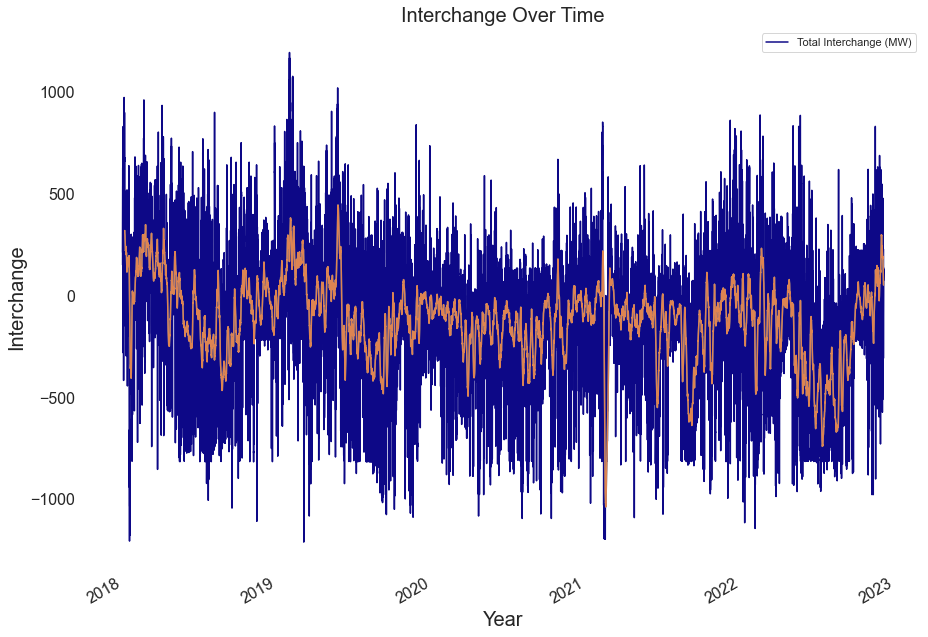

In [39]:
# creating rolling mean of grid dataframes target vlues
grid_mean = grid['Total Interchange (MW)'].rolling(window=120).mean()

# plotting target column and rolling mean
grid.plot(figsize=(15,11), colormap='plasma', ylabel='Interchange', 
                xlabel='', fontsize=16 ); grid_mean.plot()

grid_mean.plot()
plt.title('Interchange Over Time', fontsize=20)
plt.ylabel('Interchange', fontsize=20)
plt.xlabel('Year', fontsize=20)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

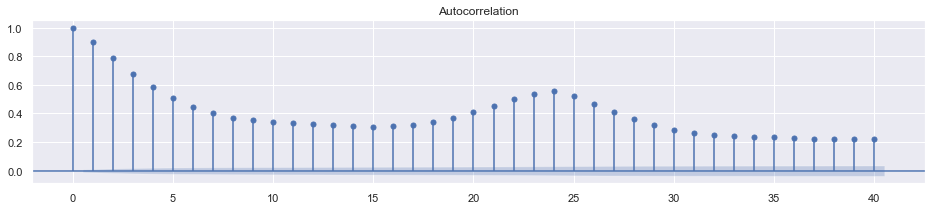

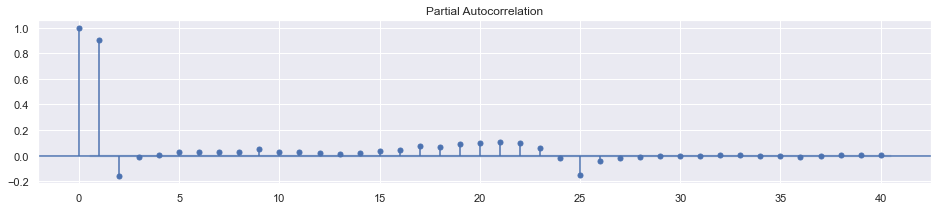

In [17]:
# plotting auto and partial autocorrelation plots
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(grid, ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(grid, ax=ax, lags=40);

In [19]:
# checking adjusted dicky fuller test to prove series is stationary
adfuller(grid)[1]

1.0072325540999747e-27

The p-value (1.01e-27) of the adjusted dicky fuller test is less than 0.05 so we can reject the null hypothesis that target data is NOT stationary.

### Down Sampling by Day

In [20]:
# down sampling the grid data to get the mean interchange for each day
grid_d = grid.resample('D').mean()

# confirming down sample
grid_d.head()

,Total Interchange (MW)
UTC Time at End of Hour,
2018-01-01,285.352941
2018-01-02,452.625000
2018-01-03,4.333333
2018-01-04,275.041667
2018-01-05,519.625000


### Combining Grid and Weather Data

In [22]:
# merging grid and weather data frames
df_d = pd.merge(grid_d, weather, left_index=True, right_index=True)

# checking merge
df_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1796 entries, 2018-01-01 to 2022-12-01
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Total Interchange (MW)  1794 non-null   float64
 1   el_paso_AWND            1796 non-null   float64
 2   corpus_christi_AWND     1796 non-null   float64
 3   dallas_AWND             1796 non-null   float64
 4   amarillo_AWND           1796 non-null   float64
 5   el_paso_PRCP            1796 non-null   float64
 6   corpus_christi_PRCP     1796 non-null   float64
 7   dallas_PRCP             1796 non-null   float64
 8   amarillo_PRCP           1796 non-null   float64
 9   el_paso_SNOW            1796 non-null   float64
 10  corpus_christi_SNOW     1796 non-null   float64
 11  dallas_SNOW             1796 non-null   float64
 12  amarillo_SNOW           1796 non-null   float64
 13  el_paso_TMAX            1796 non-null   int64  
 14  corpus_christi_TMAX   

In [23]:
# backfilling null values for total interchange
df_d['Total Interchange (MW)'].bfill(inplace=True)

# confirming null values were backfilled
df_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1796 entries, 2018-01-01 to 2022-12-01
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Total Interchange (MW)  1796 non-null   float64
 1   el_paso_AWND            1796 non-null   float64
 2   corpus_christi_AWND     1796 non-null   float64
 3   dallas_AWND             1796 non-null   float64
 4   amarillo_AWND           1796 non-null   float64
 5   el_paso_PRCP            1796 non-null   float64
 6   corpus_christi_PRCP     1796 non-null   float64
 7   dallas_PRCP             1796 non-null   float64
 8   amarillo_PRCP           1796 non-null   float64
 9   el_paso_SNOW            1796 non-null   float64
 10  corpus_christi_SNOW     1796 non-null   float64
 11  dallas_SNOW             1796 non-null   float64
 12  amarillo_SNOW           1796 non-null   float64
 13  el_paso_TMAX            1796 non-null   int64  
 14  corpus_christi_TMAX   

### Down Sampling by Week

In [26]:
# down sampling the combined dtatframe 'df_d' to get the mean interchange for each week
df_w = df_d.resample('W').mean()

# confirming down sample
df_w.head()

,Total Interchange (MW),el_paso_AWND,corpus_christi_AWND,dallas_AWND,amarillo_AWND,el_paso_PRCP,corpus_christi_PRCP,dallas_PRCP,amarillo_PRCP,el_paso_SNOW,...,dallas_SNOW,amarillo_SNOW,el_paso_TMAX,corpus_christi_TMAX,dallas_TMAX,amarillo_TMAX,el_paso_TMIN,corpus_christi_TMIN,dallas_TMIN,amarillo_TMIN
2018-01-07,264.490896,5.750000,11.281429,8.755714,10.194286,0.000000,0.000000,0.025714,0.0,0.0,...,0.0,0.0,58.714286,55.857143,50.142857,46.714286,33.142857,37.142857,28.857143,17.142857
2018-01-14,147.452381,8.150000,11.855714,12.335714,13.452857,0.014286,0.000000,0.000000,0.0,0.0,...,0.0,0.0,64.142857,69.428571,55.285714,59.857143,37.571429,42.285714,33.571429,25.428571
2018-01-21,-221.410714,7.892857,12.495714,13.741429,14.282857,0.000000,0.048571,0.084286,0.0,0.0,...,0.0,0.0,55.428571,60.000000,54.857143,52.857143,29.000000,41.000000,32.714286,19.142857
2018-01-28,-26.595238,7.572857,8.948571,10.131429,13.038571,0.000000,0.132857,0.011429,0.0,0.0,...,0.0,0.0,60.142857,68.714286,65.142857,57.571429,32.000000,47.428571,40.000000,23.428571
2018-02-04,132.250000,6.612857,10.514286,13.551429,13.070000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,70.000000,72.142857,63.857143,60.285714,37.714286,49.428571,38.571429,24.857143


## Model Selection

### Train Test Split - Daily Sampled Data

In [28]:
# creating 80% cutoff for train test split day data
cutoff = round(df_d.shape[0]*0.8)
cutoff

# creating training data
train_d = df_d[:cutoff]

# creating test data
test_d = df_d[cutoff:]

# confirming train test split
train_d.info(), test_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1437 entries, 2018-01-01 to 2021-12-07
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Total Interchange (MW)  1437 non-null   float64
 1   el_paso_AWND            1437 non-null   float64
 2   corpus_christi_AWND     1437 non-null   float64
 3   dallas_AWND             1437 non-null   float64
 4   amarillo_AWND           1437 non-null   float64
 5   el_paso_PRCP            1437 non-null   float64
 6   corpus_christi_PRCP     1437 non-null   float64
 7   dallas_PRCP             1437 non-null   float64
 8   amarillo_PRCP           1437 non-null   float64
 9   el_paso_SNOW            1437 non-null   float64
 10  corpus_christi_SNOW     1437 non-null   float64
 11  dallas_SNOW             1437 non-null   float64
 12  amarillo_SNOW           1437 non-null   float64
 13  el_paso_TMAX            1437 non-null   int64  
 14  corpus_christi_TMAX   

(None, None)

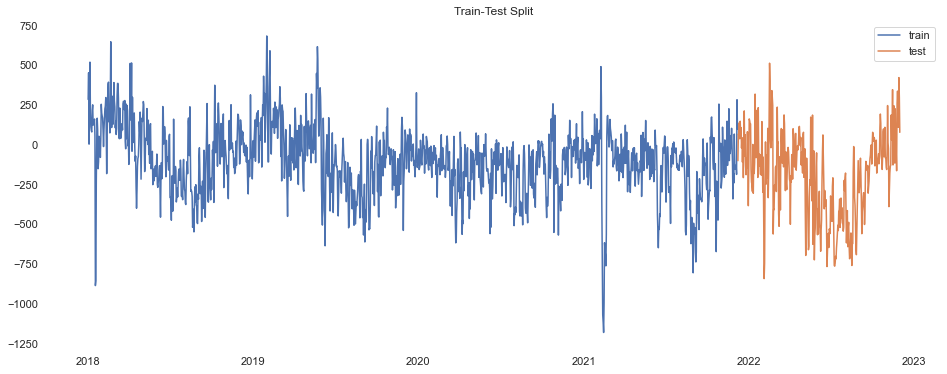

In [56]:
# ploting train/test split
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train_d['Total Interchange (MW)'], label='train')
ax.plot(test_d['Total Interchange (MW)'], label='test')
ax.set_title('Train-Test Split');
plt.legend();

### Train Test Split - Weekly Sampled Data

In [29]:
# creating 80% cutoff for train test split week data
cutoff = round(df_w.shape[0]*0.8)
cutoff

# creating training data
train_w = df_w[:cutoff]

# creating test data
test_w = df_w[cutoff:]

# confirming train test split
train_w.info(), test_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 206 entries, 2018-01-07 to 2021-12-12
Freq: W-SUN
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Total Interchange (MW)  206 non-null    float64
 1   el_paso_AWND            206 non-null    float64
 2   corpus_christi_AWND     206 non-null    float64
 3   dallas_AWND             206 non-null    float64
 4   amarillo_AWND           206 non-null    float64
 5   el_paso_PRCP            206 non-null    float64
 6   corpus_christi_PRCP     206 non-null    float64
 7   dallas_PRCP             206 non-null    float64
 8   amarillo_PRCP           206 non-null    float64
 9   el_paso_SNOW            206 non-null    float64
 10  corpus_christi_SNOW     206 non-null    float64
 11  dallas_SNOW             206 non-null    float64
 12  amarillo_SNOW           206 non-null    float64
 13  el_paso_TMAX            206 non-null    float64
 14  corpus_chri

(None, None)

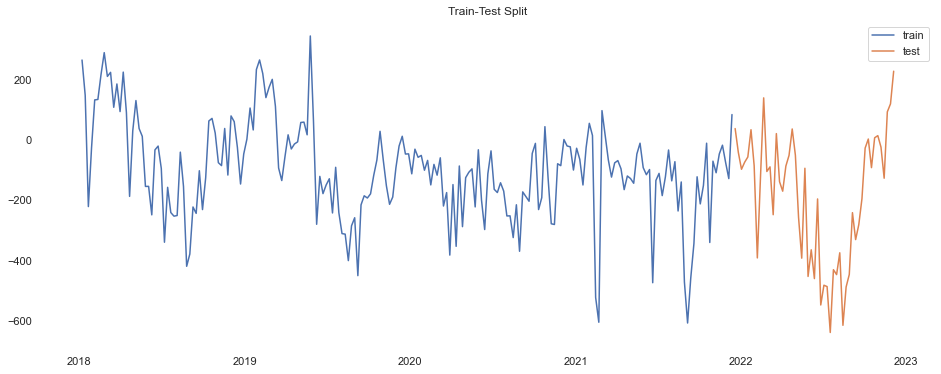

In [57]:
# ploting train/test split
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train_w['Total Interchange (MW)'], label='train')
ax.plot(test_w['Total Interchange (MW)'], label='test')
ax.set_title('Train-Test Split');
plt.legend();

### Creating Baseline - Daily Sampled Data

Creating baseline SARIMAX model with daily sampled data and the defualt ARIMA parameters, using a seasonal order (s=7) of a week. We used root mean square error as our metric for evaulating the performance of our model.

In [30]:
# creating baseline SARIMAX model with defualt ARIMA paramters and seasonality (s=7) of a week
model_base_d = SARIMAX(train_d['Total Interchange (MW)'], exog=train_d[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], order=(1, 0, 0), seasonal_order=(1,0,0,7))
res_model_base_d = model_base_d.fit()
print(res_model_base_d.summary())

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:            Total Interchange (MW)   No. Observations:                 1437
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood               -9224.952
Date:                           Thu, 08 Dec 2022   AIC                          18495.905
Time:                                   21:02:03   BIC                          18617.122
Sample:                               01-01-2018   HQIC                         18541.159
                                    - 12-07-2021                                         
Covariance Type:                             opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
el_paso_AWND            0.9988      1.369      0.729      0.466      -1.685       3.683
corpus_christi_A

In [ ]:
#                                      SARIMAX Results                                     
# =========================================================================================
# Dep. Variable:            Total Interchange (MW)   No. Observations:                 1437
# Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood               -9224.952
# Date:                           Thu, 08 Dec 2022   AIC                          18495.905
# Time:                                   21:02:03   BIC                          18617.122
# Sample:                               01-01-2018   HQIC                         18541.159
#                                     - 12-07-2021                                         
# Covariance Type:                             opg                                         
# =======================================================================================
#                           coef    std err          z      P>|z|      [0.025      0.975]
# ---------------------------------------------------------------------------------------
# el_paso_AWND            0.9988      1.369      0.729      0.466      -1.685       3.683
# corpus_christi_AWND     6.4964      1.392      4.667      0.000       3.768       9.224
# dallas_AWND             2.0608      1.315      1.567      0.117      -0.518       4.639
# amarillo_AWND           0.9039      1.095      0.825      0.409      -1.243       3.051
# el_paso_PRCP           36.8736     33.803      1.091      0.275     -29.380     103.127
# corpus_christi_PRCP    20.8883     10.760      1.941      0.052      -0.201      41.977
# dallas_PRCP            38.7026     10.531      3.675      0.000      18.062      59.344
# amarillo_PRCP          52.8237     18.543      2.849      0.004      16.480      89.167
# el_paso_SNOW           -6.4237     55.682     -0.115      0.908    -115.558     102.711
# corpus_christi_SNOW  6.031e-14      0.025   2.38e-12      1.000      -0.050       0.050
# dallas_SNOW          -310.3088     44.139     -7.030      0.000    -396.819    -223.798
# amarillo_SNOW         -44.1531      6.808     -6.485      0.000     -57.497     -30.809
# el_paso_TMAX           -0.4143      0.660     -0.628      0.530      -1.708       0.879
# corpus_christi_TMAX     0.5405      0.666      0.811      0.417      -0.766       1.847
# dallas_TMAX            -0.5626      0.756     -0.744      0.457      -2.044       0.919
# amarillo_TMAX          -0.4183      0.526     -0.795      0.426      -1.449       0.613
# el_paso_TMIN           -1.6794      0.932     -1.801      0.072      -3.507       0.148
# corpus_christi_TMIN    -0.7877      0.946     -0.832      0.405      -2.642       1.067
# dallas_TMIN            -0.2405      1.020     -0.236      0.814      -2.240       1.759
# amarillo_TMIN          -0.0522      0.890     -0.059      0.953      -1.797       1.692
# ar.L1                   0.6127      0.016     37.362      0.000       0.581       0.645
# ar.S.L7                 0.1123      0.023      4.913      0.000       0.067       0.157
# sigma2               2.193e+04    656.575     33.400      0.000    2.06e+04    2.32e+04
# ===================================================================================
# Ljung-Box (L1) (Q):                   2.08   Jarque-Bera (JB):              1648.53
# Prob(Q):                              0.15   Prob(JB):                         0.00
# Heteroskedasticity (H):               1.07   Skew:                            -0.50
# Prob(H) (two-sided):                  0.45   Kurtosis:                         8.15
# ===================================================================================

# Warnings:
# [1] Covariance matrix calculated using the outer product of gradients (complex-step).
# [2] Covariance matrix is singular or near-singular, with condition number 4.25e+21. Standard errors may be unstable.

In [31]:
# making predictions on test set
model_base_d_test_preds = res_model_base_d.predict(start=test_d.index[0], end=test_d.index[-1], exog=test_d[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], typ='levels')

# evauluating model by calculating root mean square error for test set
model_base_d_error=rmse(model_base_d_test_preds, test_d['Total Interchange (MW)'])
model_base_d_error

245.035627299752

In [32]:
# daily baseline model rmse
# model_base_d_error = 245.035627299752

### Creating Baseline Model - Weekly Sampled Data

Creating baseline SARIMAX model with weekly sampled data and the defualt ARIMA parameters, using a seasonal order (s=4) of approximately a month. We used root mean square error as our metric for evaulating the performance of our model.

In [33]:
# creating baseline SARIMAX model with defualt ARIMA paramters and seasonality (s=4) of approximately a month
model_base_w = SARIMAX(train_w['Total Interchange (MW)'], exog=train_w[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], order=(1, 0, 0), seasonal_order=(1,0,0,4))
res_model_base_w = model_base_w.fit()
print(res_model_base_w.summary())

                                     SARIMAX Results                                     
Dep. Variable:            Total Interchange (MW)   No. Observations:                  206
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 4)   Log Likelihood               -1249.894
Date:                           Thu, 08 Dec 2022   AIC                           2545.788
Time:                                   21:11:20   BIC                           2622.329
Sample:                               01-07-2018   HQIC                          2576.743
                                    - 12-12-2021                                         
Covariance Type:                             opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
el_paso_AWND           -0.7592      6.464     -0.117      0.906     -13.427      11.909
corpus_christi_A

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#                                      SARIMAX Results                                     
# =========================================================================================
# Dep. Variable:            Total Interchange (MW)   No. Observations:                  206
# Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 4)   Log Likelihood               -1249.894
# Date:                           Thu, 08 Dec 2022   AIC                           2545.788
# Time:                                   21:11:20   BIC                           2622.329
# Sample:                               01-07-2018   HQIC                          2576.743
#                                     - 12-12-2021                                         
# Covariance Type:                             opg                                         
# =======================================================================================
#                           coef    std err          z      P>|z|      [0.025      0.975]
# ---------------------------------------------------------------------------------------
# el_paso_AWND           -0.7592      6.464     -0.117      0.906     -13.427      11.909
# corpus_christi_AWND     3.4408      5.051      0.681      0.496      -6.459      13.341
# dallas_AWND            13.9245      5.587      2.492      0.013       2.975      24.874
# amarillo_AWND           0.1443      5.144      0.028      0.978      -9.938      10.226
# el_paso_PRCP          304.4879    186.305      1.634      0.102     -60.662     669.638
# corpus_christi_PRCP    -0.1567     53.875     -0.003      0.998    -105.750     105.437
# dallas_PRCP           124.5777     66.467      1.874      0.061      -5.695     254.850
# amarillo_PRCP         196.1445    110.414      1.776      0.076     -20.262     412.551
# el_paso_SNOW          -10.8998    498.634     -0.022      0.983    -988.204     966.404
# corpus_christi_SNOW  1.642e-12      0.014   1.19e-10      1.000      -0.027       0.027
# dallas_SNOW         -1315.7416    570.487     -2.306      0.021   -2433.875    -197.608
# amarillo_SNOW        -198.0060     57.340     -3.453      0.001    -310.390     -85.622
# el_paso_TMAX            5.8912      2.908      2.026      0.043       0.192      11.591
# corpus_christi_TMAX    -0.8947      3.152     -0.284      0.777      -7.073       5.284
# dallas_TMAX            -9.6016      4.066     -2.361      0.018     -17.572      -1.631
# amarillo_TMAX           2.8883      3.105      0.930      0.352      -3.197       8.974
# el_paso_TMIN           -2.8792      3.078     -0.936      0.350      -8.911       3.153
# corpus_christi_TMIN     1.1718      3.955      0.296      0.767      -6.581       8.924
# dallas_TMIN             3.7713      5.135      0.734      0.463      -6.293      13.836
# amarillo_TMIN          -6.6052      3.877     -1.704      0.088     -14.203       0.993
# ar.L1                   0.4015      0.072      5.574      0.000       0.260       0.543
# ar.S.L4                 0.0358      0.081      0.444      0.657      -0.122       0.194
# sigma2               1.101e+04   1180.621      9.326      0.000    8696.792    1.33e+04
# ===================================================================================
# Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                22.67
# Prob(Q):                              0.56   Prob(JB):                         0.00
# Heteroskedasticity (H):               1.19   Skew:                            -0.45
# Prob(H) (two-sided):                  0.47   Kurtosis:                         4.35
# ===================================================================================

# Warnings:
# [1] Covariance matrix calculated using the outer product of gradients (complex-step).
# [2] Covariance matrix is singular or near-singular, with condition number 9.96e+20. Standard errors may be unstable.

In [34]:
# making predictions on test set
model_base_w_test_preds = res_model_base_w.predict(start=test_w.index[0], end=test_w.index[-1], exog=test_w[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], typ='levels')

# evauluating model by calculating root mean square error for test set
model_base_w_error=rmse(model_base_w_test_preds, test_w['Total Interchange (MW)'])
model_base_w_error

176.4763804216187

In [ ]:
# weekly baseline model rmse
# model_base_d_error = 176.4763804216187

### Grid Search - Daily Sampled Data

Grid searching across SARIMAX model's hyperparameters with daily sampled data and using a seasonal order of a month (s=30). We used root mean square error as our metric for determining the best hyperparameters.

In [ ]:
# SARIMAX Grid Search using daily data and seasonal order of 30 days (1 month)
p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 30 # the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
rmse_list = []
count = 0
# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(endog=train_d['Total Interchange (MW)'], exog=train_d[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=True,
                                             enforce_invertibility=False)
            model = model.fit()
            model_preds = model.predict(start=test_d.index[0], end=test_d.index[-1], exog=test_d[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], typ='levels')
            rmse_result = rmse(model_preds, test_d['Total Interchange (MW)'])
            combs.update({rmse_result : [combination, seasonal_combination]})
            rmse_list.append(rmse_result)
            
        except:
            continue
        count += 1
        print(count)
            
best_rmse_d = min(rmse_list)
# Modeling and forcasting
best_model_d = sm.tsa.statespace.SARIMAX(endog=train_d['Total Interchange (MW)'], exog=train_d[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], order=combs[best_rmse_d][0], seasonal_order=combs[best_rmse_d][1],
                                             enforce_stationarity=True,
                                             enforce_invertibility=False)
best_model_d = best_model_d.fit()

In [ ]:
# printing best daily model summary
print(best_model_d.summary())

In [ ]:
#                                      SARIMAX Results                                      
# ==========================================================================================
# Dep. Variable:             Total Interchange (MW)   No. Observations:                 1437
# Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -9092.116
# Date:                            Thu, 08 Dec 2022   AIC                          18234.232
# Time:                                    10:10:24   BIC                          18365.445
# Sample:                                01-01-2018   HQIC                         18283.272
#                                      - 12-07-2021                                         
# Covariance Type:                              opg                                         
# =======================================================================================
#                           coef    std err          z      P>|z|      [0.025      0.975]
# ---------------------------------------------------------------------------------------
# el_paso_AWND            1.9076      1.616      1.180      0.238      -1.261       5.076
# corpus_christi_AWND     5.8994      1.810      3.259      0.001       2.352       9.447
# dallas_AWND             3.3854      1.617      2.094      0.036       0.217       6.554
# amarillo_AWND           2.0847      1.346      1.549      0.121      -0.553       4.722
# el_paso_PRCP            5.3260     41.670      0.128      0.898     -76.346      86.998
# corpus_christi_PRCP    13.9125     12.482      1.115      0.265     -10.551      38.376
# dallas_PRCP            17.3467     12.781      1.357      0.175      -7.704      42.397
# amarillo_PRCP          15.8255     22.092      0.716      0.474     -27.474      59.125
# el_paso_SNOW            2.2206     89.671      0.025      0.980    -173.531     177.972
# corpus_christi_SNOW -1.149e-15      0.071  -1.61e-14      1.000      -0.140       0.140
# dallas_SNOW           -62.6518     72.040     -0.870      0.384    -203.849      78.545
# amarillo_SNOW          13.3007     14.073      0.945      0.345     -14.282      40.883
# el_paso_TMAX           -1.2923      0.876     -1.475      0.140      -3.010       0.425
# corpus_christi_TMAX     2.9059      0.973      2.986      0.003       0.999       4.813
# dallas_TMAX            -1.8996      0.995     -1.910      0.056      -3.849       0.050
# amarillo_TMAX           2.1508      0.688      3.127      0.002       0.803       3.499
# el_paso_TMIN           -1.3847      1.193     -1.161      0.246      -3.722       0.953
# corpus_christi_TMIN     1.3148      1.193      1.102      0.271      -1.024       3.654
# dallas_TMIN            -3.0319      1.339     -2.265      0.024      -5.655      -0.408
# amarillo_TMIN          -4.7972      1.105     -4.341      0.000      -6.963      -2.631
# ar.L1                   0.6287      0.025     25.296      0.000       0.580       0.677
# ma.L1                  -0.9734      0.009   -103.423      0.000      -0.992      -0.955
# ar.S.L30               -0.0325      0.038     -0.850      0.395      -0.108       0.042
# ma.S.L30               -0.9601      0.031    -30.688      0.000      -1.021      -0.899
# sigma2               2.798e+04   1314.613     21.287      0.000    2.54e+04    3.06e+04
# ===================================================================================
# Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                54.18
# Prob(Q):                              0.43   Prob(JB):                         0.00
# Heteroskedasticity (H):               0.90   Skew:                            -0.11
# Prob(H) (two-sided):                  0.26   Kurtosis:                         3.94
# ===================================================================================

# Warnings:
# [1] Covariance matrix calculated using the outer product of gradients (complex-step).
# [2] Covariance matrix is singular or near-singular, with condition number 1.17e+22. Standard errors may be unstable.

In [ ]:
# printing best rmse from daily grid search
best_rmse_d

The best_rmse_d was 220.39453544565706

### Grid Search - Weekly Sampled Data

Grid searching across SARIMAX model's hyperparameters with weekly sampled data and using a seasonal order of quarter of a year (s=13). We used root mean square error as our metric for determining the best hyperparameters.

In [ ]:
# SARIMAX Grid Search using weekly data and seasonality of 13 months (1/4 year)
p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 13 # the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
rmse_list = []
count = 0
# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(endog=train_w['Total Interchange (MW)'], exog=train_w[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=True,
                                             enforce_invertibility=False)
            model = model.fit()
            model_preds = model.predict(start=test_w.index[0], end=test_w.index[-1], exog=test_w[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], typ='levels')
            rmse_result = rmse(model_preds, test_w['Total Interchange (MW)'])
            combs.update({rmse_result : [combination, seasonal_combination]})
            rmse_list.append(rmse_result)
            
        except:
            continue
        count += 1
        print(count)
            
best_rmse_w = min(rmse_list)
# Modeling and forcasting
best_model_w = sm.tsa.statespace.SARIMAX(endog=train_w['Total Interchange (MW)'], exog=train_w[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], order=combs[best_rmse_w][0], seasonal_order=combs[best_rmse_w][1],
                                             enforce_stationarity=True,
                                             enforce_invertibility=False)
best_model_w = best_model_w.fit()

In [ ]:
# printing best weekly model summary
print(best_model_w.summary())

In [35]:
#                                      SARIMAX Results                                      
# ==========================================================================================
# Dep. Variable:             Total Interchange (MW)   No. Observations:                  206
# Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 13)   Log Likelihood               -1187.402
# Date:                            Wed, 07 Dec 2022   AIC                           2422.804
# Time:                                    20:54:19   BIC                           2501.108
# Sample:                                01-07-2018   HQIC                          2454.514
#                                      - 12-12-2021                                         
# Covariance Type:                              opg                                         
# =======================================================================================
#                           coef    std err          z      P>|z|      [0.025      0.975]
# ---------------------------------------------------------------------------------------
# el_paso_AWND           -8.0438      6.159     -1.306      0.192     -20.114       4.027
# corpus_christi_AWND     4.7291      5.229      0.904      0.366      -5.519      14.977
# dallas_AWND            19.3146      5.989      3.225      0.001       7.577      31.052
# amarillo_AWND          -0.4025      5.923     -0.068      0.946     -12.012      11.207
# el_paso_PRCP          164.9069    183.934      0.897      0.370    -195.598     525.411
# corpus_christi_PRCP    11.0461     48.913      0.226      0.821     -84.821     106.913
# dallas_PRCP           141.2882     56.914      2.482      0.013      29.739     252.838
# amarillo_PRCP         239.2838     90.021      2.658      0.008      62.846     415.721
# el_paso_SNOW          407.5231    211.901      1.923      0.054      -7.795     822.841
# corpus_christi_SNOW  4.602e-12   1.32e-09      0.003      0.997   -2.59e-09     2.6e-09
# dallas_SNOW         -1419.5781    575.360     -2.467      0.014   -2547.263    -291.893
# amarillo_SNOW        -207.7970     55.193     -3.765      0.000    -315.973     -99.621
# el_paso_TMAX            5.7291      3.146      1.821      0.069      -0.437      11.895
# corpus_christi_TMAX     0.4190      3.800      0.110      0.912      -7.029       7.867
# dallas_TMAX           -10.0912      4.371     -2.309      0.021     -18.658      -1.524
# amarillo_TMAX           4.2121      3.229      1.305      0.192      -2.116      10.540
# el_paso_TMIN           -2.8144      3.428     -0.821      0.412      -9.534       3.905
# corpus_christi_TMIN     3.2628      4.092      0.797      0.425      -4.758      11.283
# dallas_TMIN             0.3874      5.242      0.074      0.941      -9.888      10.662
# amarillo_TMIN          -5.8459      4.519     -1.293      0.196     -14.704       3.012
# ar.L1                   0.5626      0.143      3.932      0.000       0.282       0.843
# ma.L1                  -0.1325      0.173     -0.766      0.444      -0.471       0.206
# ma.S.L13               -0.8350      0.095     -8.822      0.000      -1.020      -0.649
# sigma2               1.199e+04   1497.261      8.008      0.000    9054.743    1.49e+04
# ===================================================================================
# Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.80
# Prob(Q):                              0.83   Prob(JB):                         0.67
# Heteroskedasticity (H):               1.11   Skew:                            -0.11
# Prob(H) (two-sided):                  0.67   Kurtosis:                         3.23
# ===================================================================================

# Warnings:
# [1] Covariance matrix calculated using the outer product of gradients (complex-step).
# [2] Covariance matrix is singular or near-singular, with condition number 2.45e+21. Standard errors may be unstable.

In [ ]:
# printing best rmse from weekly grid search
best_rmse_w

The best_rmse_w was 175.10264914271613

## Results

Based on our grid searches the model with the lowest RMSE had a weekly-level resolution and these parameters:

SARIMAX, order=(1, 0, 1), seasonal_order=(0, 1, 1, 13)

However, we believe that having a daily-level resolution provides our stakeholder more actionable information. Our best daily-level resolution model outperfromed the baseline and had the following hyparameters:

SARIMAX, order=(1, 1, 1), seasonal_order=(1, 1, 1, 30)

The ability to predict when the interchange value of the grid goes from a positive to negative state is important for grid distribution planning. Therefore, to evaluate our models we created a function to compute the accuracy score of its predictions. 

### Accuracy Score - Weekly Sampled Model

In [46]:
# running best weekly model
best_model_w = sm.tsa.statespace.SARIMAX(endog=train_w['Total Interchange (MW)'], exog=train_w[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], order=(1, 0, 1) , seasonal_order=(0, 1, 1, 13)).fit()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
# getting predictions for best weekly model
best_model_w_preds = best_model_w.predict(start=test_w.index[0], end=test_w.index[-1], exog=test_w[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], typ='levels')

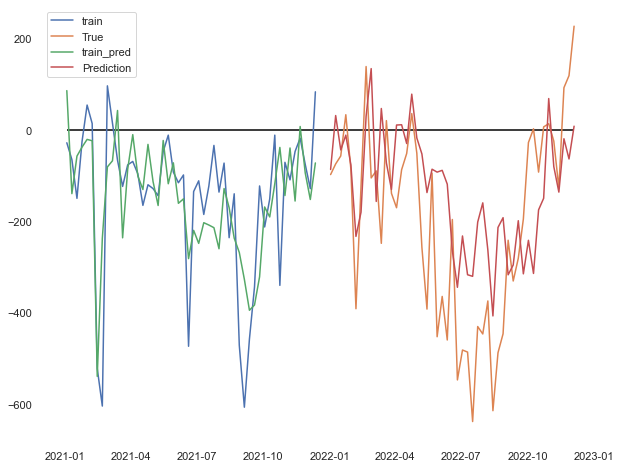

In [61]:
# plotting predictions
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(train_w['Total Interchange (MW)']['2021':'2022'], label='train')
ax.plot(test_w['Total Interchange (MW)']['2022':], label='True')
ax.plot(best_model_w.predict(typ='levels')['2021':'2022'], label='train_pred')
ax.plot(best_model_w_preds['2022':], label='Prediction')
ax.hlines(y=0, xmin=min(train_w['2021':'2022'].index), xmax=max(best_model_w_preds.index), colors='black')
plt.legend();

In [48]:
# creating columns for prediction and test which calculates the difference between each datapoint and 
# previous datapoint
test_w['PDiff'] = best_model_w_preds.diff() 
test_w['TDiff'] = test_w['Total Interchange (MW)'].diff() 

<ipython-input-48-c8ca9a3ebda7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_w['PDiff'] = best_model_w_preds.diff()
<ipython-input-48-c8ca9a3ebda7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_w['TDiff'] = test_w['Total Interchange (MW)'].diff()


In [49]:
# creating function for listing whether or not value switches sign (between positive and negative)
def switcher(main, diff):

    switch = []
    for i in main:
        for j in diff:
            if i > 0 and j > i:
                switch.append(True)
            elif i < 0 and np.abs(j) > np.abs(i):
                switch.append(True)
            else:
                switch.append(False)
    return switch

predSwitch_w = switcher(best_model_w_preds, test_w['PDiff'])
trueSwitch_w = switcher(test_w['Total Interchange (MW)'], test_w['TDiff'])

In [50]:
# evaluating our best weekly model's accuracy in predicting interchange switches
accuracy_w = 0
for i, j in zip(predSwitch_w, trueSwitch_w):
    if i == j:
        accuracy_w += 1     
print(accuracy_w/len(trueSwitch_w))

0.6647443291041907


Our best weekly sampled model had an accuracy of 66%

### Accuracy Score - Daily Sampled Model

In [40]:
# running best daily model
best_model_d = sm.tsa.statespace.SARIMAX(endog=train_d['Total Interchange (MW)'], exog=train_d[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], order=(1, 1, 1) , seasonal_order=(1, 1, 1, 30)).fit()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
# getting predictions for best daily model
best_model_d_preds = best_model_d.predict(start=test_d.index[0], end=test_d.index[-1], exog=test_d[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']], typ='levels')

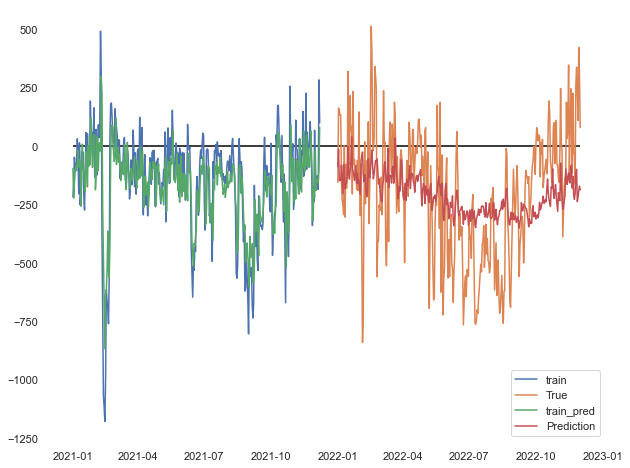

In [84]:
# plotting predictions
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(train_d['Total Interchange (MW)']['2021':'2022'], label='train')
ax.plot(test_d['Total Interchange (MW)']['2022':], label='True')
ax.plot(best_model_d.predict(typ='levels')['2021':'2022'], label='train_pred')
ax.plot(best_model_d_preds['2022':], label='Prediction')
ax.hlines(y=0, xmin=min(train_d['2021':'2022'].index), xmax=max(best_model_d_preds.index), colors='black')
plt.legend();
plt.savefig("Data/modelPlot.jpg", dpi=600, bbox_inches="tight", transparent=False);

In [43]:
# creating columns for prediction and test which calculates the difference between each datapoint and 
# previous datapoint
test_d['PDiff'] = best_model_d_preds.diff() 
test_d['TDiff'] = test_d['Total Interchange (MW)'].diff() 

<ipython-input-43-0c77dea3bc4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_d['PDiff'] = best_model_d_preds.diff()
<ipython-input-43-0c77dea3bc4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_d['TDiff'] = test_d['Total Interchange (MW)'].diff()


In [44]:
# creating function for listing whether or not value switches sign (between positive and negative)
def switcher(main, diff):

    switch = []
    for i in main:
        for j in diff:
            if i > 0 and j > i:
                switch.append(True)
            elif i < 0 and np.abs(j) > np.abs(i):
                switch.append(True)
            else:
                switch.append(False)
    return switch

predSwitch_d = switcher(best_model_d_preds, test_d['PDiff'])
trueSwitch_d = switcher(test_d['Total Interchange (MW)'], test_d['TDiff'])

In [45]:
# evaluating our best daily model's accuracy in predicting interchange switches
accuracy_d = 0
for i, j in zip(predSwitch_d, trueSwitch_d):
    if i == j:
        accuracy_d += 1     
print(accuracy_d/len(trueSwitch_d))

0.7085683692708777


Our best daily sampled model had an accuracy score of 71%. So as you can see even though our best weekly sampled model had a lower error it was slightly worse than our best daily sampled model at predicting when the grid's interchange value swithches signs (between positive and negative).

### Exogenous Features

Based on the p-values of all of our exogenous features in our best daily model, we found that the maximum temperature, snow and precipication were most frequently statistically significant across the regions. This demonstrates their importance as an indicator for predicting total interchange values.

In [82]:
# =======================================================================================
#                           coef    std err          z      P>|z|      [0.025      0.975]
# ---------------------------------------------------------------------------------------
# el_paso_AWND           -8.0438      6.159     -1.306      0.192     -20.114       4.027
# corpus_christi_AWND     4.7291      5.229      0.904      0.366      -5.519      14.977
# dallas_AWND            19.3146      5.989      3.225      0.001       7.577      31.052
# amarillo_AWND          -0.4025      5.923     -0.068      0.946     -12.012      11.207
# el_paso_PRCP          164.9069    183.934      0.897      0.370    -195.598     525.411
# corpus_christi_PRCP    11.0461     48.913      0.226      0.821     -84.821     106.913
# dallas_PRCP           141.2882     56.914      2.482      0.013      29.739     252.838
# amarillo_PRCP         239.2838     90.021      2.658      0.008      62.846     415.721
# el_paso_SNOW          407.5231    211.901      1.923      0.054      -7.795     822.841
# corpus_christi_SNOW  4.602e-12   1.32e-09      0.003      0.997   -2.59e-09     2.6e-09
# dallas_SNOW         -1419.5781    575.360     -2.467      0.014   -2547.263    -291.893
# amarillo_SNOW        -207.7970     55.193     -3.765      0.000    -315.973     -99.621
# el_paso_TMAX            5.7291      3.146      1.821      0.069      -0.437      11.895
# corpus_christi_TMAX     0.4190      3.800      0.110      0.912      -7.029       7.867
# dallas_TMAX           -10.0912      4.371     -2.309      0.021     -18.658      -1.524
# amarillo_TMAX           4.2121      3.229      1.305      0.192      -2.116      10.540
# el_paso_TMIN           -2.8144      3.428     -0.821      0.412      -9.534       3.905
# corpus_christi_TMIN     3.2628      4.092      0.797      0.425      -4.758      11.283
# dallas_TMIN             0.3874      5.242      0.074      0.941      -9.888      10.662
# amarillo_TMIN          -5.8459      4.519     -1.293      0.196     -14.704       3.012
# ar.L1                   0.5626      0.143      3.932      0.000       0.282       0.843
# ma.L1                  -0.1325      0.173     -0.766      0.444      -0.471       0.206
# ma.S.L13               -0.8350      0.095     -8.822      0.000      -1.020      -0.649
# sigma2               1.199e+04   1497.261      8.008      0.000    9054.743    1.49e+04
# ===================================================================================

### Forecasting

Below is a visual of our best daily model's forecast for the year 2023.

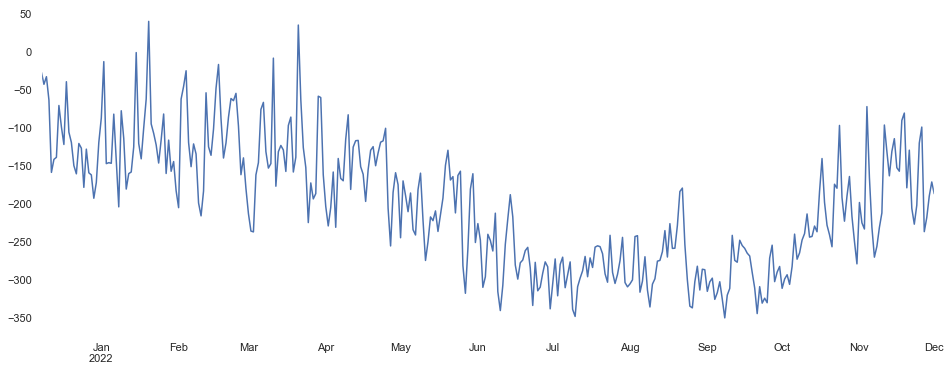

In [86]:
# plotting forecast for 2023
forecast = best_model_d.get_forecast(steps=359,  exog=test_d[['el_paso_AWND', 'corpus_christi_AWND',
       'dallas_AWND', 'amarillo_AWND', 'el_paso_PRCP', 'corpus_christi_PRCP',
       'dallas_PRCP', 'amarillo_PRCP', 'el_paso_SNOW', 'corpus_christi_SNOW',
       'dallas_SNOW', 'amarillo_SNOW', 'el_paso_TMAX', 'corpus_christi_TMAX',
       'dallas_TMAX', 'amarillo_TMAX', 'el_paso_TMIN', 'corpus_christi_TMIN',
       'dallas_TMIN', 'amarillo_TMIN']])

forecast.summary_frame()['mean'].plot(figsize=(16,6));
plt.savefig("Data/forecastPlot.jpg", dpi=600, bbox_inches="tight", transparent=False)